In [1]:
from langchain_ollama import ChatOllama
import PIL.Image, PIL.ImageDraw
from io import BytesIO

import requests
from pydantic import BaseModel, Field
import base64
from typing import Optional

In [2]:
OLLAMA_BASE_URL = "http://host.docker.internal:11434"
OLLAMA_MODEL_ID = "qwen2.5vl"

In [3]:
# class DetectedObject(BaseModel):
    
#     bbox_2d:list[int] = Field(description="the bounding box of the detected object")
#     label:str = Field(description="the class label of the detected object")
#     sub_label:Optional[str] = Field(default=None, description="the subclass label of the detected object, if any")

In [4]:
llm = ChatOllama(base_url=OLLAMA_BASE_URL, model=OLLAMA_MODEL_ID)

In [27]:
img_path = "/workspace/data/scooters.jpg"
# img_path = "/workspace/data/street.jpg"

In [28]:
pil_image = PIL.Image.open(img_path)

In [29]:
img = BytesIO()
pil_image.save(img, format="JPEG")

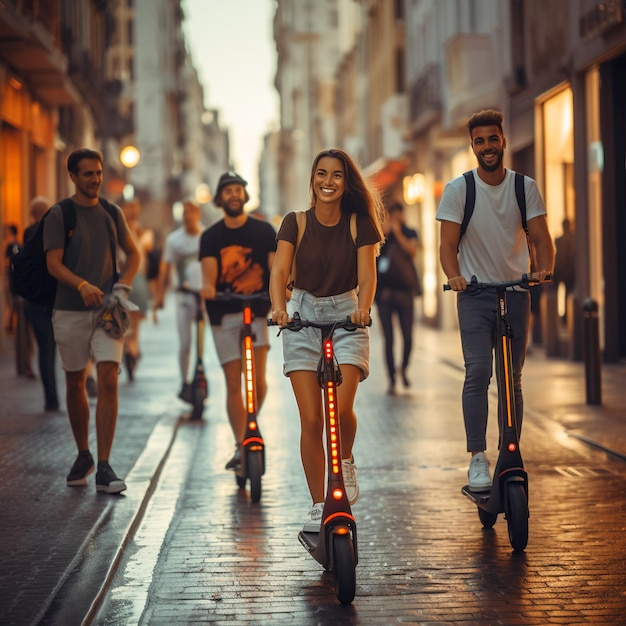

In [30]:
pil_image

In [31]:
img_b64=base64.b64encode(img.getvalue()).decode("utf8")
img_data_url = f'data:image/jpeg;base64,{img_b64}'

In [32]:
message = {
    "role":"user",
    "content": [
        {
            "type": "text",
            "text": 'Detect all humans in the foreground of the image and return their locations in the form of coordinates. The format of output should be:\n```json\n{“bbox_2d”: [x1, y1, x2, y2], “label”: “human”, “sub_label”: “walking”, “riding scooter”, "riding motorcycle", etc}```. Return no more than 10 bounding boxes.',
            # "text": "What is in the foreground in the picture?",
        },
        {
            "type": "image_url",
            'image_url' : {
                'url' : img_data_url
            }
        },
    ]
}



In [33]:
res = llm.invoke([message])

In [34]:
res.content

'```json\n[\n    {"bbox_2d": [262, 202, 377, 587], "label": "human", "sub_label": "riding scooter"},\n    {"bbox_2d": [428, 136, 543, 470], "label": "human", "sub_label": "riding scooter"},\n    {"bbox_2d": [192, 196, 272, 470], "label": "human", "sub_label": "riding scooter"},\n    {"bbox_2d": [37, 202, 140, 500], "label": "human", "sub_label": "walking"},\n    {"bbox_2d": [148, 105, 200, 370], "label": "human", "sub_label": "walking"},\n    {"bbox_2d": [375, 50, 420, 388], "label": "human", "sub_label": "walking"},\n    {"bbox_2d": [20, 195, 60, 370], "label": "human", "sub_label": "walking"}\n]\n```'

In [35]:
import json

In [36]:
json_data = json.loads(res.text().replace("```json", "").replace("```",""))

In [37]:
json_data

[{'bbox_2d': [262, 202, 377, 587],
  'label': 'human',
  'sub_label': 'riding scooter'},
 {'bbox_2d': [428, 136, 543, 470],
  'label': 'human',
  'sub_label': 'riding scooter'},
 {'bbox_2d': [192, 196, 272, 470],
  'label': 'human',
  'sub_label': 'riding scooter'},
 {'bbox_2d': [37, 202, 140, 500], 'label': 'human', 'sub_label': 'walking'},
 {'bbox_2d': [148, 105, 200, 370], 'label': 'human', 'sub_label': 'walking'},
 {'bbox_2d': [375, 50, 420, 388], 'label': 'human', 'sub_label': 'walking'},
 {'bbox_2d': [20, 195, 60, 370], 'label': 'human', 'sub_label': 'walking'}]

In [38]:
pil_image.width, pil_image.height

(626, 626)

In [39]:
draw = PIL.ImageDraw.ImageDraw(pil_image)

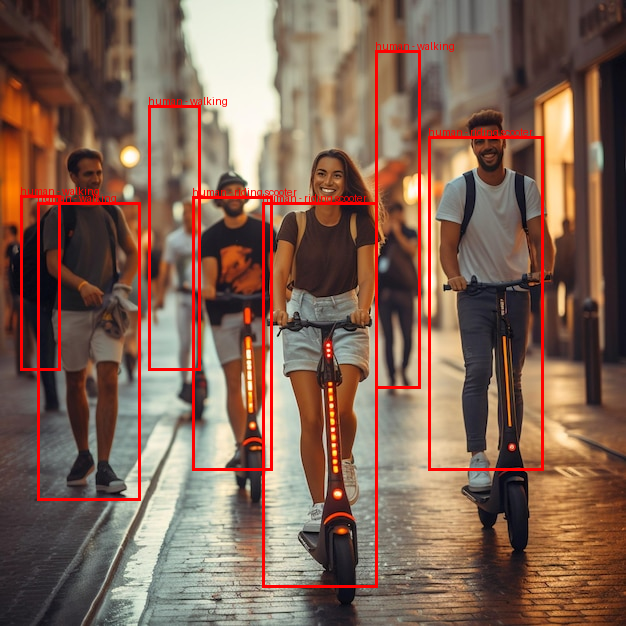

In [40]:
for box in json_data:
    x1, y1, x2, y2 = box['bbox_2d']
    draw.rectangle([x1, y1, x2, y2], outline='red', width=3)
    # Also add text for labels
    text = f"{box['label']} - {box['sub_label']}"
    draw.text((x1, y1 - 10), text, fill='red')

pil_image